In [1]:
import numpy as np
from numpy import power, sinh, cosh, tanh, pi, log, sqrt, exp, cos, sin
import matplotlib.pyplot as plt
import os
import sys

In [258]:
class DEFormula:
    """二重指数関数型数値積分公式(DE公式)
    [-1, 1]の定積分を行う。
    変数変換は x = φ(t) = tanh((pi/2)*sinh(t))
    """

    def __init__(self, f, f_denom, f_phi, f_phi_denom, grad_f_phi_denom):
        """ クラスの初期化
        Arguments
        ---------
            f(float -> float): 被積分関数
            f_denom(float->float): fの分母
            f_phi(float -> float): 合成関数f(φ(t))
            f_phi_denom(float -> float): f_phiの分母
            grad_f_phi_denom(float -> float): d/dt(f_phi_denom)
        Parameters
        ----------
            BETA(float): 変数変換により定まる定数。打ち切りmから幅hを計算する際に用いる。
            EPS(float): 特異性を判定する際に用いる閾値。非常に小さい数。
        """
        self.f = f
        self.f_denom = f_denom
        self.f_phi = f_phi
        self.f_phi_denom = f_phi_denom
        self.grad_f_phi_denom = grad_f_phi_denom
        self.BETA = pi/4
        self.EPS = 1e-10

    def phi(self, t):
        """変数変換 x = φ(t)
        """
        return tanh((pi/2)*sinh(t))

    def grad_phi(self, t):
        """ d/dt φ(t)
        """
        return pi * cosh(t) / (1 + cosh(pi * sinh(t)))

    def grad_phi_denom(self, t):
        """ d/dt φ(t)の分母
        """
        return 1 + cosh(pi * sinh(t))
    
    def g(self, t):
        """ g(t) := f(φ(t)) * d/dt φ(t)
        """
        return self.f_phi(t) * self.grad_phi(t)

    def search_d(self):
        """ g(z) (z: 複素数)の特異点のうち、実軸に最も近いものを求め、
        実軸からの距離dを返す。

        [原理]
        変数変換φ(t)=tanh(pi/2sinh(t))により、g(z) = f(φ(z))φ'(z)の特異点について、
        φ'(z)の分母に着目することにより 0 <= d <= pi/2 の範囲にある。
        よって、f(φ(z)))の特異点を探せばよい。f(φ(z))の分母をgivenとすると、
        非線形方程式denominator_of_f(φ(z)) = 0 の解をニュートン法により求めれば、
        その解の虚部の絶対値とpi/2のうち小さい方がdである。

        Return
        ------
            d (float): 求めたパラメータd
        """
        # 初期値点生成
        img_part_list = np.linspace(-pi/2, pi/2, 200)
        z0_list = []
        for img_part in img_part_list:
            for real_part in np.linspace(-100, 100, 200):
                z0_list.append(real_part + img_part * 1.j)
        
        d = pi/2
        for z in z0_list:
            # 各初期値に関してニュートン法
            diff = 1e10
            z0 = z
            cnt = 0 #ループ100回を超えたら発散と判定
            flag = 0
            while diff > 1e-6 and cnt < 100:
                cnt += 1
                z_before = z
                if grad_f_phi_denom(z_before) == 0.:
                    flag = 1
                    break
                z = z_before - self.f_phi_denom(z_before) / self.grad_f_phi_denom(z_before)
                diff = np.abs(z - z_before)
            if flag:
                continue
            print(f"z0 = {z0} || z = {z}")
            if np.abs(z.imag) < d:
                d = np.abs(z.imag)
        return d

    def m_to_h(self, m, d):
        """ 打ち切り点数mから離散化幅hを計算する。
        Arguments
        ---------
            m(int): 打ち切り点数
            d(float): search_d()で求めたパラメータd
        """
        return log((2*pi*d*m)/self.BETA)/m

    def solve(self, m):
        """ 打ち切り点数mをもとに数値積分を実行する。

        Arguments
        --------
            m(int): 打ち切り点数
        
        Return
        ------
            value(float): 数値積分の結果
        """
        d = self.search_d()
        print("################ DE Formula ##################")
        print("d =", d)
        print("m =", m)
        h = self.m_to_h(m, d)
        print("h =", h)
        value = 0.0
        print(f"STEP 000 || value = {value}")
        for j in range(-m, m):
            if value == np.inf:
                break
            value += 0.5 * (self.g(j*h) + self.g((j+1)*h)) * h
            print(f"STEP {str(j+m+1).zfill(3)} || value = {value}")
        return value


In [259]:
def f(x):
    return 1 / sqrt(1-x**2)

def f_denom(x):
    return sqrt(1-x**2)

def f_phi(t):
    return cosh((pi/2)*sinh(t))

def f_phi_denom(t):
    return 1

def grad_f_phi_denom(t):
    return 0

de = DEFormula(f, f_denom, f_phi, f_phi_denom, grad_f_phi_denom)

In [260]:
de.solve(m=20)

################ DE Formula ##################
d = 1.5707963267948966
m = 20
h = 0.2763378260261641
STEP 000 || value = 0.0
STEP 001 || value = 3.893231957508051e-64
STEP 002 || value = 1.48428163067973e-48
STEP 003 || value = 9.164202969297388e-37
STEP 004 || value = 7.540066776840615e-28
STEP 005 || value = 4.0900101771700626e-21
STEP 006 || value = 4.91944412801795e-16
STEP 007 || value = 3.2939088210854774e-12
STEP 008 || value = 2.4726331007514656e-09
STEP 009 || value = 3.559696705594648e-07
STEP 010 || value = 1.4911316299887071e-05
STEP 011 || value = 0.00025099789455892356
STEP 012 || value = 0.002162166973480206
STEP 013 || value = 0.011343895820008248
STEP 014 || value = 0.041045472992207586
STEP 015 || value = 0.11217368842500572
STEP 016 || value = 0.24782407842225437
STEP 017 || value = 0.4653981383504555
STEP 018 || value = 0.7697785443037749
STEP 019 || value = 1.1485386528960102
STEP 020 || value = 1.570796326794898
STEP 021 || value = 1.9930540006937856
STEP 022 || va

3.1415926535897953

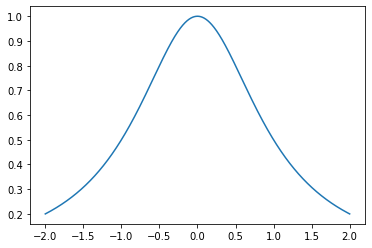

In [249]:
xx = np.linspace(-2, 2, 10000)
yy = de.f(xx)
plt.plot(xx, yy)

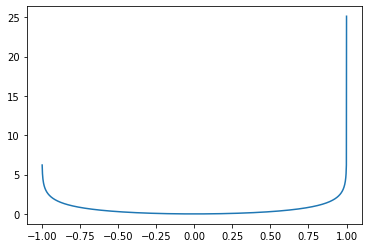

In [16]:
def g(t):
    return -log(1 - (tanh((pi/2)*sinh(t))) ** 2) * pi * cosh(t) / (1 + cosh(pi * sinh(t)))
def f(x):
    return -log(1-x**2)
xx = np.arange(-10, 10, 0.001)
ff = f(xx)
plt.plot(xx, ff)


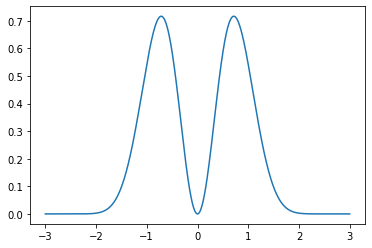

In [17]:
tt = np.arange(-3, 3, 0.001)
gg = g(tt)
plt.plot(tt, gg)